# ML Workbench Sample --- Image Classification

<br><br>
### _Introduction of ML Workbench_
ML Workbench provides an easy command line interface for machine learning life cycle, which involves four stages:
* analyze: gather stats and metadata of the training data, such as numeric stats, vocabularies, etc. Analysis results are used in transforming raw data into numeric features, which can be consumed by training directly.  
* transform: explicitly transform raw data into numeric features which can be used for training.
* train: training model using transformed data.
* predict/batch_predict: given a few instances of prediction data, make predictions instantly / with large number of instances of prediction data, make predictions in a batched fassion.


There are "local" and "cloud" run mode for each stage. "cloud" run mode is recommended if your data is big.
<br><br>
ML Workbench supports numeric, categorical, text, image training data. For each type, there are a set of "transforms" to choose from. The "transforms" indicate how to convert the data into numeric features. For images, it is converted to fixed size vectors representing high level features.
<br><br>

### _Transfer learning using Inception Package - Cloud Run Experience With Large Data_
ML Workbench supports image transforms (image to vec) with transfer learning.

This notebook continues the codifies the capabilities discussed in this [blog post](https://cloud.google.com/blog/big-data/2016/12/how-to-train-and-classify-images-using-google-cloud-machine-learning-and-cloud-dataflow). In a nutshell, it uses the pre-trained inception model as a starting point and then uses transfer learning to train it further on additional, customer-specific images. For explanation, simple flower images are used. Compared to training from scratch, the time and costs are drastically reduced.

This notebook does preprocessing, training and prediction by calling CloudML API instead of running them "locally" in the Datalab container. It uses full data.

In [3]:
# ML Workbench magics (%%ml) are under google.datalab.contrib namespace. It is not enabled by default and you need to import it before use.
import google.datalab.contrib.mlworkbench.commands

# Setup

In [2]:
# Create a temp GCS bucket. If the bucket already exists and you don't have permissions, rename it.
!gsutil mb gs://flower-datalab-demo-bucket-large-data

Creating gs://flower-datalab-demo-bucket-large-data/...


Next cell, we will create a dataset representing our training data.

In [5]:
%%ml dataset create
name: flower_data_full
format: csv
train: gs://cloud-datalab/sampledata/flower/train3000.csv
eval: gs://cloud-datalab/sampledata/flower/eval670.csv
schema:
    - name: image_url
      type: STRING
    - name: label
      type: STRING

# Analyze

Analysis step includes computing numeric stats (i.e. min/max), categorical classes, text vocabulary and frequency, etc. Run "%%ml analyze --help" for usage. The analysis results will be used for transforming raw data into numeric features that the model can deal with. For example, to convert categorical value to a one-hot vector ("Monday" becomes [1, 0, 0, 0, 0, 0, 0]). The data may be very large, so sometimes a cloud run is needed by adding --cloud flag. Cloud run will start BigQuery jobs, which may incur some costs.

In this case, analysis step only collects unique labels.

Note that we run analysis only on training data, but not evaluation data.

In [6]:
%%ml analyze --cloud
output: gs://flower-datalab-demo-bucket-large-data/analysis
data: flower_data_full
features:
    image_url:
        transform: image_to_vec
    label:
        transform: target

Analyzing column image_url...
column image_url analyzed.
Analyzing column label...
column label analyzed.
Updated property [core/project].


In [7]:
# Check analysis results
!gsutil list gs://flower-datalab-demo-bucket-large-data/analysis

gs://flower-datalab-demo-bucket-large-data/analysis/features.json
gs://flower-datalab-demo-bucket-large-data/analysis/schema.json
gs://flower-datalab-demo-bucket-large-data/analysis/stats.json
gs://flower-datalab-demo-bucket-large-data/analysis/vocab_label.csv


# Transform

With analysis results we can transform raw data into numeric features. This needs to be done for both training and eval data. The data may be very large, so sometimes a cloud pipeline is needed by adding --cloud. Cloud run is implemented by DataFlow jobs, so it may incur some costs.

In this case, transform is required. It downloads image, resizes it, and generate embeddings from each image by running a pretrained TensorFlow graph. Note that it creates two jobs --- one for training data and one for eval data.

In [ ]:
# Remove previous results
!gsutil -m rm gs://flower-datalab-demo-bucket-large-data/transform

In [12]:
%%ml transform --cloud
analysis: gs://flower-datalab-demo-bucket-large-data/analysis
output: gs://flower-datalab-demo-bucket-large-data/transform
data: flower_data_full

/usr/local/lib/python2.7/dist-packages/apache_beam/io/gcp/gcsio.py:113: DeprecationWarning: object() takes no parameters
  super(GcsIO, cls).__new__(cls, storage_client))
/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)
running sdist
running egg_info
creating trainer.egg-info
writing requirements to trainer.egg-info/requires.txt
writing trainer.egg-info/PKG-INFO
writing top-level names to trainer.egg-info/top_level.txt
writing dependency_links to trainer.egg-info/dependency_links.txt
writing manifest file 'trainer.egg-info/SOURCES.txt'
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'

running check

creating trainer-1.0.0
creating trainer-1.0.0/trainer
creating trainer-1.0.0/trainer.egg-info
copying files to trainer-1.0.0...
copying setup.py -> trainer-1.0.0
copying trainer/__init__

After transformation is done, create a new dataset referencing the training data.

In [15]:
%%ml dataset create
name: flower_data_full_transformed
format: transformed
train: gs://flower-datalab-demo-bucket-large-data/transform/train-*
eval: gs://flower-datalab-demo-bucket-large-data/transform/eval-*

# Train

Training starts from transformed data. If training work is too much to do on the local VM, --cloud is recommended so training happens in cloud, in a distributed way. Run %%ml train --help for details.

Training in cloud is implemented with Cloud ML Engine. It may incur some costs.

In [ ]:
# Remove previous training results.
!gsutil -m rm -r gs://flower-datalab-demo-bucket-large-data/train

In [16]:
%%ml train --cloud
output: gs://flower-datalab-demo-bucket-large-data/train
analysis: gs://flower-datalab-demo-bucket-large-data/analysis
data: flower_data_full_transformed
model_args:
    model: dnn_classification
    hidden-layer-size1: 100
    top-n: 0
cloud_config:
    region: us-central1
    scale_tier: BASIC

Job "trainer_task_171019_051802" submitted. Click here to view cloud log.

TensorBoard was started successfully with pid 17594. Click here to access it.

After training is complete, you should see model files like the following.

In [17]:
# List the model files
!gsutil list gs://flower-datalab-demo-bucket-large-data/train/model 

gs://flower-datalab-demo-bucket-large-data/train/model/
gs://flower-datalab-demo-bucket-large-data/train/model/saved_model.pb
gs://flower-datalab-demo-bucket-large-data/train/model/assets.extra/
gs://flower-datalab-demo-bucket-large-data/train/model/variables/


# Batch Prediction

Batch prediction performs prediction in a batched fashion. The data can be large, and is specified by files.  

Note that, we use the "evaluation_model" which sits in "evaluation_model_dir". There are two models created in training. One is a regular model under "model" dir, the other is "evaluation_model". The difference is the regular one takes prediction data without target and the evaluation model takes data with target and output the target as is. So evaluation model is good for evaluating the quality of the model because the targets and predicted values are included in output.

In [18]:
%%ml batch_predict --cloud
model: gs://flower-datalab-demo-bucket-large-data/train/evaluation_model
output: gs://flower-datalab-demo-bucket-large-data/evaluation
cloud_config:
    region: us-central1
data:
    csv: gs://cloud-datalab/sampledata/flower/eval670.csv

Job "prediction_171019_054302" submitted. Click here to view cloud log.

In [19]:
# after prediction is done, check the output
!gsutil list -l -h gs://flower-datalab-demo-bucket-large-data/evaluation

       0 B  2017-10-19T05:51:38Z  gs://flower-datalab-demo-bucket-large-data/evaluation/prediction.errors_stats-00000-of-00001
       0 B  2017-10-19T04:26:01Z  gs://flower-datalab-demo-bucket-large-data/evaluation/prediction.results-00000-of-00001
  9.91 KiB  2017-10-19T05:51:38Z  gs://flower-datalab-demo-bucket-large-data/evaluation/prediction.results-00000-of-00006
 21.86 KiB  2017-10-19T05:51:38Z  gs://flower-datalab-demo-bucket-large-data/evaluation/prediction.results-00001-of-00006
  9.35 KiB  2017-10-19T05:51:38Z  gs://flower-datalab-demo-bucket-large-data/evaluation/prediction.results-00002-of-00006
 17.92 KiB  2017-10-19T05:51:38Z  gs://flower-datalab-demo-bucket-large-data/evaluation/prediction.results-00003-of-00006
 60.27 KiB  2017-10-19T05:51:38Z  gs://flower-datalab-demo-bucket-large-data/evaluation/prediction.results-00004-of-00006
 13.68 KiB  2017-10-19T05:51:38Z  gs://flower-datalab-demo-bucket-large-data/evaluation/prediction.results-00005-of-00006
TOTAL: 8 objects, 1

In [21]:
# Take a look at the file.
!gsutil cat -r -500 gs://flower-datalab-demo-bucket-large-data/evaluation/prediction.results-00000-of-00006

 "sunflowers": 0.023919522762298584, "predicted": "daisy", "daisy": 0.5709955096244812}
{"target": "sunflowers", "dandelion": 6.407364847637394e-16, "tulips": 1.1489890098563176e-21, "roses": 3.703789355800949e-23, "sunflowers": 1.0, "predicted": "sunflowers", "daisy": 4.062632231285804e-18}
{"target": "sunflowers", "dandelion": 3.1532248600391055e-12, "tulips": 1.2175611572835896e-15, "roses": 1.7113922181424834e-16, "sunflowers": 1.0, "predicted": "sunflowers", "daisy": 6.292334708835057e-12}


Prediction results are in JSON format. We can load the results into BigQuery table and performa analysis.

In [23]:
import google.datalab.bigquery as bq

schema = [
  {'name': 'predicted', 'type': 'STRING'},
  {'name': 'target', 'type': 'STRING'},
  {'name': 'daisy', 'type': 'FLOAT'},  
  {'name': 'dandelion', 'type': 'FLOAT'},  
  {'name': 'roses', 'type': 'FLOAT'},
  {'name': 'sunflowers', 'type': 'FLOAT'},
  {'name': 'tulips', 'type': 'FLOAT'},
]

bq.Dataset('image_classification_results').create()
t = bq.Table('image_classification_results.flower').create(schema = schema, overwrite = True)
t.load('gs://flower-datalab-demo-bucket-large-data/evaluation/prediction.results-*', mode='overwrite', source_format='json')

Job bradley-playground/job_6U6Mnzk1o-KCAdLob2PwMs4_0lWk completed

Check wrong predictions.

In [24]:
%%bq query
SELECT * FROM image_classification_results.flower WHERE predicted != target

predicted,target,daisy,dandelion,roses,sunflowers,tulips
roses,daisy,0.000107081861643,4.2452506932e-06,0.985331714153,0.01447784435,7.90482226876e-05
roses,daisy,0.00336904148571,0.0817719474435,0.898831009865,0.00606627622619,0.00996168423444
roses,daisy,9.25164749788e-06,3.04345193491e-09,0.999936938286,1.34516176331e-06,5.23670387338e-05
roses,daisy,6.38103125894e-09,1.10664151454e-11,0.999925494194,2.96761953678e-07,7.42329939385e-05
tulips,daisy,4.83075413005e-10,4.30522035799e-08,1.14557883535e-06,3.37842357112e-06,0.999995470047
dandelion,daisy,8.15960166038e-19,1.0,3.36299384949e-26,7.30872310153e-27,3.52697304699e-24
dandelion,daisy,0.0406570062041,0.959276914597,2.83383229771e-07,4.56821435364e-05,2.0248007786e-05
dandelion,daisy,3.2681695302e-05,0.999963641167,3.94953673322e-07,3.09938968712e-06,2.75721021126e-07
dandelion,daisy,5.03894037607e-10,1.0,9.46683408883e-16,2.09550150669e-13,4.55575959173e-14
dandelion,daisy,0.139625295997,0.859617710114,1.33036223815e-06,0.000684840255417,7.08434599801e-05


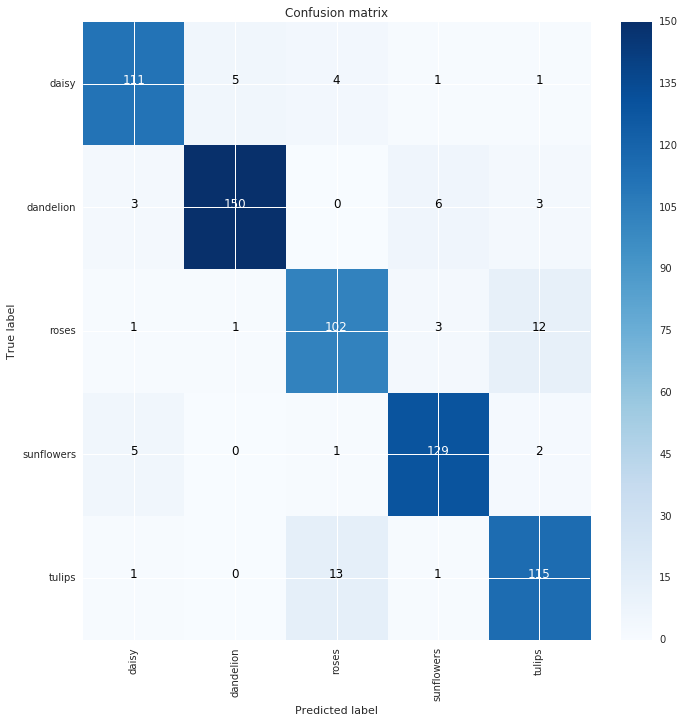

In [26]:
%%ml evaluate confusion_matrix --plot
bigquery: image_classification_results.flower

In [27]:
%%ml evaluate accuracy
bigquery: image_classification_results.flower

,target,accuracy,count
0,daisy,0.909836,122
1,roses,0.857143,119
2,tulips,0.884615,130
3,dandelion,0.925926,162
4,sunflowers,0.941606,137
5,_all,0.905970,670


# Online Prediction and Build Your Own Prediction Client

Please see "Flower Classification (small dataset experience)" notebook for how to deploy the trained model and build your own prediction client.

# Cleanup

In [ ]:
!gsutil -m rm -rf gs://flower-datalab-demo-bucket-large-data